## Visuals of 3DCORE for Solar Orbiter April 2020 CME event
#### for Forstner et al. 2020

py3dcore used here pull from git 1.1.3


done


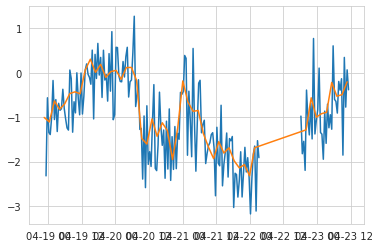

In [21]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc

import numpy as np
from datetime import timedelta
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import multiprocessing

import astropy
import astropy.constants as const
import astropy.units as unit
from astropy.coordinates import SkyCoord


import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

from sunpy.coordinates import frames

import py3dcore
import heliosat


#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
#os.system('jupyter nbconvert --to script psp_3dcore.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
    
animdirectory='results/animations'
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)
    
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


#--------------------- load solar orbiter data (made with heliocats)
filemag='data/mag/solo_2020_icme_april_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 


#--------------------- load Wind data
filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


#cut out data around event from wind data time series
windbegin_ind=np.where(win.time > parse_time('2020-04-15 00:00').datetime)[0][0]
windend_ind=np.where(win.time > parse_time('2020-04-22 00:00').datetime)[0][0]
win=win[windbegin_ind:windend_ind]

#------------------------- load position data

#load position data (made with heliocats)
#[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
#      pickle.load( open( 'data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))

#load position data (made with heliocats)
#[psp, bepi, solo, earth, mars, mercury,venus,sta,stb]= \
#      pickle.load( open( 'data/positions_HCI_1hr.p', "rb" ))

#these are 1 minute HCI positions for the April May 2020 time range
[psp, bepi, solo, earth, mars, mercury,venus,sta]= \
      pickle.load( open( 'data/positions_HCI_1minute.p', "rb" ))


#convert to mdates
psp_numtime=mdates.date2num(psp.time)
bepi_numtime=mdates.date2num(bepi.time)
solo_numtime=mdates.date2num(solo.time)
sta_numtime=mdates.date2num(sta.time)
earth_numtime=mdates.date2num(earth.time)


#------------------------- read data from Johan
het_gcr=pickle.load( open( 'data/epd/het_gcr_data.pickle', "rb" ))
sopo_nm=pickle.load( open( 'data/epd/sopo_nm_data.pickle', "rb" ))
crater1r=pickle.load( open( 'data/epd/crater_30min_data.pickle', "rb" ))
crater2r=pickle.load( open( 'data/epd/crater_orbitaverage_data.pickle', "rb" ))


#normalize to percentage drop

solo_norm_date = datetime.datetime(2020, 4, 19, 8, 58,tzinfo=datetime.timezone.utc)
het_gcr_norm = (het_gcr / het_gcr[solo_norm_date - datetime.timedelta(hours=3):solo_norm_date].mean() - 1) * 100  # FD in percent

earth_norm_date = datetime.datetime(2020, 4, 20, 1, 33,tzinfo=datetime.timezone.utc)
sopo_nm_norm = (sopo_nm / sopo_nm[earth_norm_date - datetime.timedelta(hours=3):earth_norm_date].mean() - 1) * 100  # FD in percent

crater1=crater1r.to_frame()
crater2=crater2r.to_frame()

crater_norm_date1 = datetime.datetime(2020, 4, 20, 1, 33,tzinfo=datetime.timezone.utc)
crater_norm1 = (crater1 / crater1[crater_norm_date1 - datetime.timedelta(hours=3):crater_norm_date1].mean() - 1) * 100  # FD in percent
#check mean between the two dates manually
crater_norm2 = (crater2 / 23.3 - 1) * 100  # FD in percent


plt.plot(crater_norm1)
plt.plot(crater_norm2)
print('done')

In [79]:
############### Model Settings


#get model parameters from ABC fit analysis
obj = py3dcore.fitting.ABCSMC()
obj.load('data/3dcore/SOLO_APRIL_FORBUSH_DELTA=4.dat')

#parameters are in obj.particles
#set launch time
t_launch=obj.t_launch
print('t_launch from file is ',t_launch)

######** manual set
t_launch = datetime.datetime(2020, 4, 15, 8,tzinfo=datetime.timezone.utc)
print('t_launch is manually set to ',t_launch)

#get index of best fit 
best_fit_ind=np.argmin(obj.epses)


#get parameters from mean
iparams_arr_mean = np.array([[
    np.mean(obj.particles[:,0]),      # time offset
    np.mean(obj.particles[:,1]),    # l_1 (longitude) *********************
    np.mean(obj.particles[:,2]),    # l_2 (latitude)
    np.mean(obj.particles[:,3]),      # o (inclination, orientation)
    np.mean(obj.particles[:,4]),   # d_1au (frontal width at 1AU)
    np.mean(obj.particles[:,5]),   # delta (cross-section aspect ratio)
    np.mean(obj.particles[:,6]),      # r_0 (initialization distance in solar radii)
    np.mean(obj.particles[:,7]),    # v_0 (initial velocty in)
    np.mean(obj.particles[:,8]),      # tau (magnetic field twist)
    np.mean(obj.particles[:,9]),      # b_s (magnetic field scaling parameter)
    np.mean(obj.particles[:,10]),     #  b_1au (magnetic field strength at 1au)
    np.mean(obj.particles[:,11]),    # Gamma (solar wind drag coefficient)
    np.mean(obj.particles[:,12]),    # v_sw (solar wind speed)
    0,#np.mean(obj.particles[:,13])
]], dtype=np.float32)


#get parameters from best fit (prefereed)
iparams_arr = np.array([[
    obj.particles[best_fit_ind,0],      # time offset
    obj.particles[best_fit_ind,1],    # l_1 (longitude) *********************
    obj.particles[best_fit_ind,2],    # l_2 (latitude)
    obj.particles[best_fit_ind,3],      # o (inclination, orientation)
    obj.particles[best_fit_ind,4],   # d_1au (frontal width at 1AU)
    obj.particles[best_fit_ind,5],   # delta (cross-section aspect ratio)
    obj.particles[best_fit_ind,6],      # r_0 (initialization distance in solar radii)
    obj.particles[best_fit_ind,7],    # v_0 (initial velocty in)
    obj.particles[best_fit_ind,8],      # tau (magnetic field twist)
    obj.particles[best_fit_ind,9],      # b_s (magnetic field scaling parameter)
    obj.particles[best_fit_ind,10],     #  b_1au (magnetic field strength at 1au)
    obj.particles[best_fit_ind,11],    # Gamma (solar wind drag coefficient)
    obj.particles[best_fit_ind,12],    # v_sw (solar wind speed)
    obj.particles[best_fit_ind,13],
    obj.particles[best_fit_ind,14],
    0,
]], dtype=np.float32)


#model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj = py3dcore.models.TTGHv2(t_launch, runs=1, use_gpu=False)

model_obj.update_iparams(iparams_arr, seed=42)

#generic 3DCORE parameters, no fit
#iparams_arr2 = np.array([[
#    0,      # time offset
#    0,    # l_1 (longitude)
#    0,    # l_2 (latitude)
#    0,      # o (inclination, orientation)
#    0.20,   # d_1au (frontal width at 1AU)
#    4,   # delta (cross-section aspect ratio)
#    5,      # r_0 (initialization distance in solar radii)
#    350,    # v_0 (initial velocty in)
#    -2,      # tau (magnetic field twist)
#    1,      # b_s (magnetic field scaling parameter)
#    15,     #  b_1au (magnetic field strength at 1au)
#    1.5,    # Gamma (solar wind drag coefficient)
#    300,    # v_sw (solar wind speed)
#    0       # sigma (measurement noise)
#]], dtype=np.float32)

param_strings=['time offset', 'longitude', 'latitude', 'inclination', 'd_1au','width ratio', 'delta (cross-section aspect ratio)', 'r_0 launch radius (R_sun)', 'v_0 launch velocity (km/s)',  'tau (magnetic field twist)','n_a diameter expansion exponent','n_b magnetic field scaling exponent)', 'b_1au (magnetic field strength at 1au)',  'Gamma (solar wind drag coefficient)', 'v_sw (solar wind speed)', 'sigma (measurement noise)']

TP_A =  t_launch + datetime.timedelta(hours=24)
TP_B =  t_launch + datetime.timedelta(hours=120)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"



earth_color='blue'
solo_color='orange'
venus_color='mediumseagreen'
mercury_color='grey'
psp_color='black'
sta_color='red'
bepi_color='coral'



print()
print()
print('3DCORE parameters in HCI')
print()


for i in np.arange(0,len(iparams_arr.T)):     
    print(np.round(iparams_arr[0,i],3),param_strings[i])
#https://github.com/ajefweiss/py3DCORE/blob/master/py3dcore/models/ttghv2/parameters.json 
    
    
#heeq_lon=16.6 
#heeq_lon_err=4.3
#heeq_lat=-5.1
#heeq_lat_err=4.2
print()
print('done')

t_launch from file is  2020-04-15 06:00:00+00:00
t_launch is manually set to  2020-04-15 08:00:00+00:00


3DCORE parameters in HCI

0.0 time offset
128.098 longitude
-3.14 latitude
1.363 inclination
0.136 d_1au
1.0 width ratio
4.0 delta (cross-section aspect ratio)
20.0 r_0 launch radius (R_sun)
300.0 v_0 launch velocity (km/s)
-11.713 tau (magnetic field twist)
1.14 n_a diameter expansion exponent
1.64 n_b magnetic field scaling exponent)
15.33 b_1au (magnetic field strength at 1au)
1.934 Gamma (solar wind drag coefficient)
302.815 v_sw (solar wind speed)
0.0 sigma (measurement noise)

done


### functions 

In [80]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    
    #time resolution in minutes
    res_in_days=1/(24*60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    #print('data points',len(t_s))
    
    
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
   
   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)  
    
  

### measure fields

In [81]:
#t1, btot1, bxyz1 = measure(model_obj, "PSP",  t_launch, TP_A  + datetime.timedelta(hours=6), frame="HEEQ", bframe="HEEQ")
#t2, btot2, bxyz2 = measure(model_obj, "PSP",  t_launch, TP_B  + datetime.timedelta(hours=12), frame="HEEQ", bframe="HEEQ")
t1, btot1, bxyz1 = measure(model_obj, "SOLO", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="SOLO_SUN_RTN")
t2, btot2, bxyz2 = measure(model_obj, "Earth", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="HEE")


fileout='april_2020_3dcore_fit_solo_forecast_earth_forstner_2020.p'      
pickle.dump([t1,btot1,bxyz1,t2,btot2,bxyz2,model_obj], open('data/forstner_2020/'+fileout, "wb"))




### simple position plot

current frame_time_num 2020-04-19 05:07:00+00:00


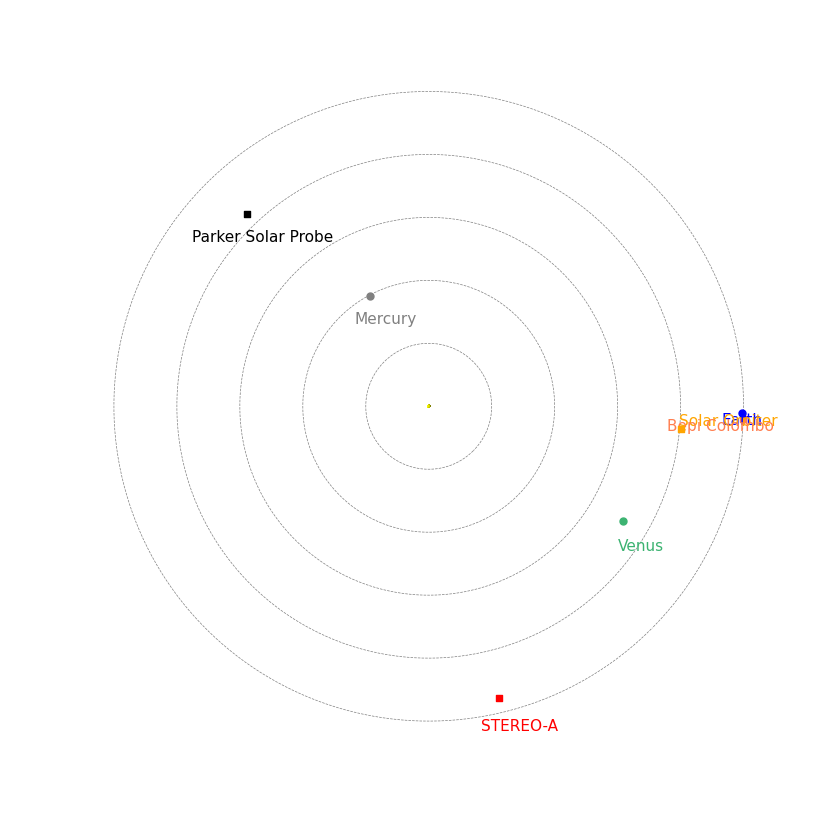

In [32]:
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0),projection='3d')  

######### tilted view
plot_configure(ax1, view_azim=40, view_elev=90, view_radius=.8)

#impact time of CME at solar orbiter 2020-04-19 05:07 UT
ti = datetime.datetime(2020, 4, 19, 5,7,0)

#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "Earth", ti, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", ti, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", ti, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", ti, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", ti, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", ti, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", ti, frame="HCI", color=bepi_color,marker='s')


frame_time_num=mdates.date2num(ti) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-(mdates.date2num(sta.time))
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-(mdates.date2num(earth.time))
earth_timeind=np.argmin(abs(dct))


fsize=15


#planet and spacecraft labels

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind]+0.08,venus.z[earth_timeind],'Venus', color=venus_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind]+0.07,mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='center',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind]+0.07,psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind]-0.15,solo.y[solo_timeind]+0.07,solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind]+0.05,bepi.y[bepi_timeind]-0.05,bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind]+0.09,sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='center',fontsize=fsize-4,verticalalignment='top')

#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.8
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.6
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.4
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.2
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


a_circle = plt.Circle((0, 0), .5,fill=False,zorder=3,linestyle='-')
ax1.add_artist(a_circle)
plt.savefig('results/plots/positions_solo_apr2020_event_hci.png', dpi=100,bbox_inches='tight')

#plt.savefig('results/plots/positions_solo_apr2020_event_tilt.png', dpi=100,bbox_inches='tight')

## model plot Figure 4 


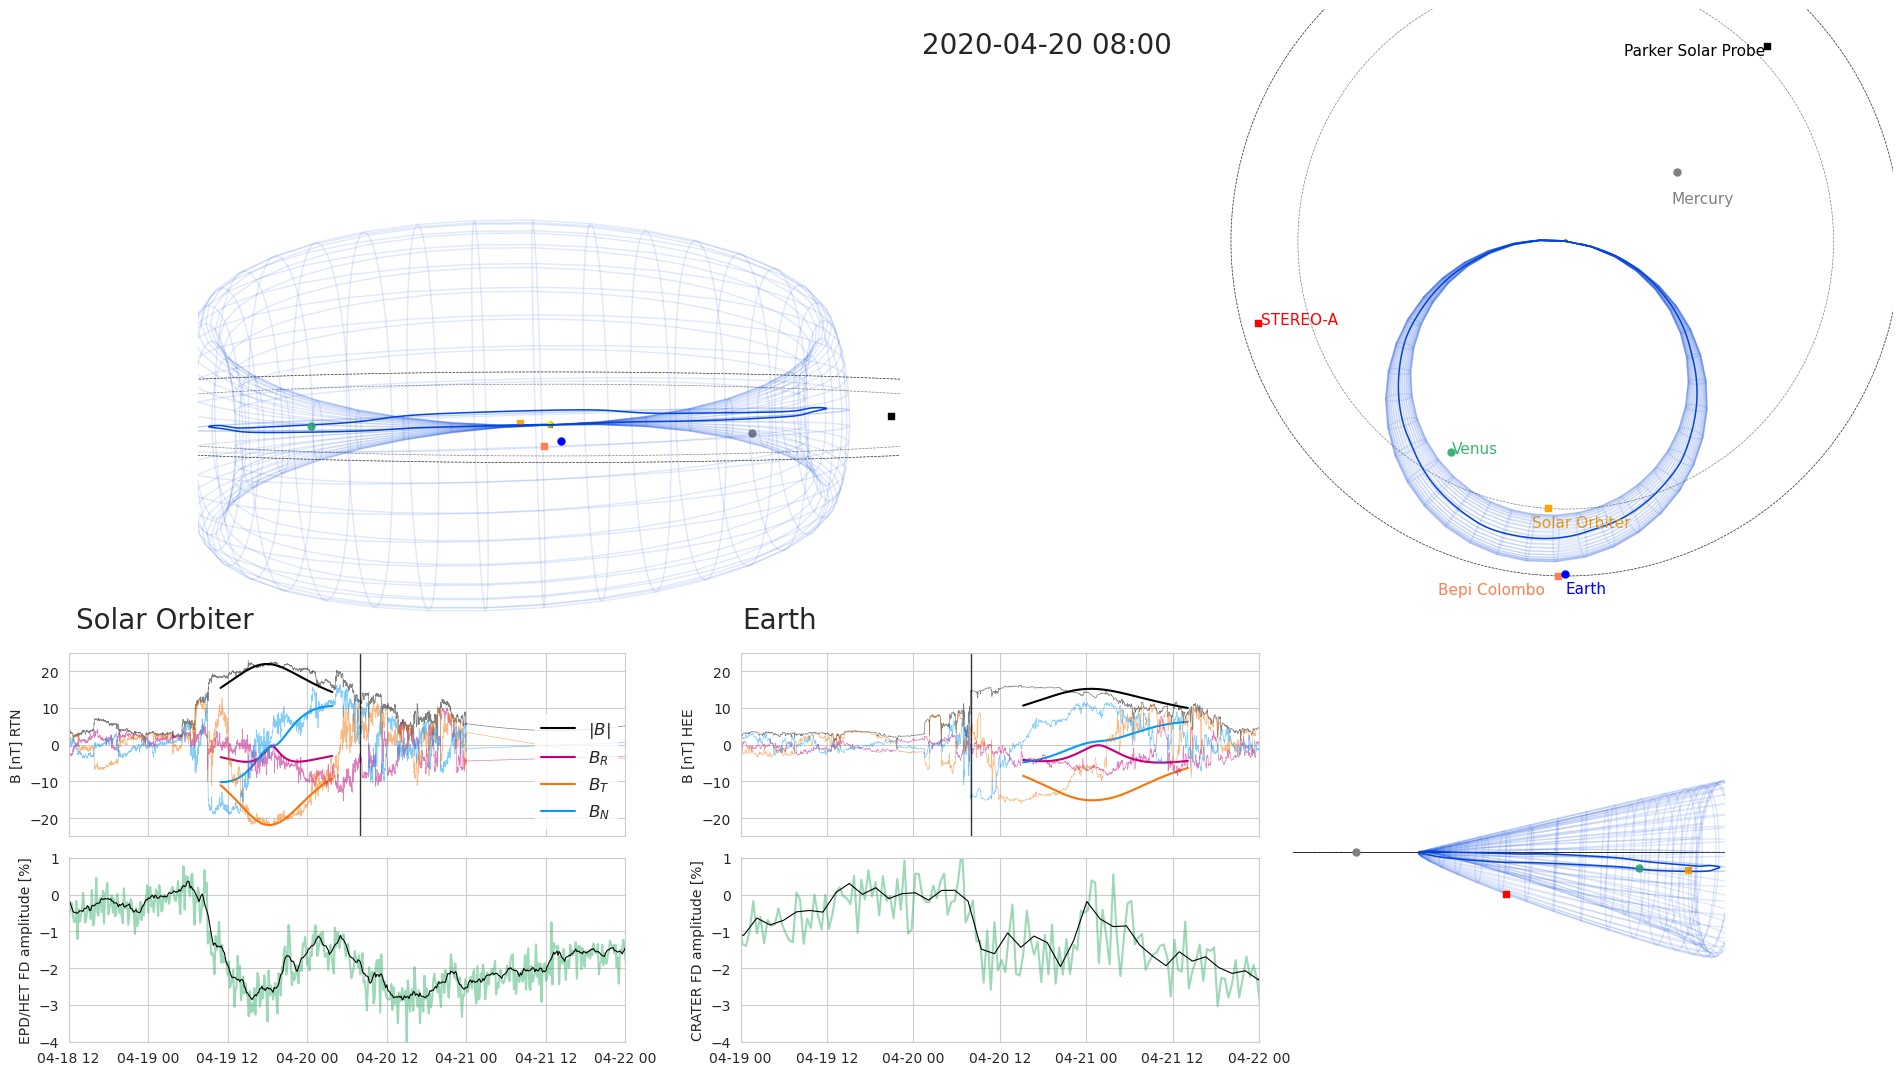

In [86]:
#%matplotlib inline
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure2(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=0, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.8
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

    #ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    #ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


    
    ax.set_axis_off()


    

#for field line plots stepsize and initial point for drawing    
field_stepsize=0.0005    
q1=np.array([1, .1, np.pi/2])

sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
ax2 = plt.subplot2grid((4, 3), (0, 2),projection='3d',rowspan=2)  
ax3 = plt.subplot2grid((4, 3), (2, 2),projection='3d')  
ax4 = plt.subplot2grid((4, 3), (2, 0))  
ax5 = plt.subplot2grid((4, 3), (3, 0))  
ax6 = plt.subplot2grid((4, 3), (3, 1))  
ax7 = plt.subplot2grid((4, 3), (3, 2))  


#manually set axes positions
#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
ax1.set_position([0,0.3,0.6,0.65], which='both')
ax2.set_position([0.65,0.35,0.35,0.65], which='both')
ax3.set_position([0.6,0,0.4,0.4], which='both')
ax4.set_position([0.05,0.22,0.29,0.17], which='both')
ax6.set_position([0.05,0.03,0.29,0.17], which='both')
ax5.set_position([0.40,0.22,0.27,0.17], which='both')
ax7.set_position([0.40,0.03,0.27,0.17], which='both')



######### tilted view
plot_configure2(ax1, view_azim=134, view_elev=-4.5, view_radius=.3)

plot_3dcore(ax1, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))


plot_traj(ax1, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')


#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")#
#plot_traj(ax1, "Earth", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

#dotted trajectory
#plot_traj(ax1, "Earth", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

#shift center
plot_shift(ax1,0.3,-0.5,0.5,0)



########### top view panel
plot_configure2(ax2, view_azim=134, view_elev=90, view_radius=.4)
#plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
plot_3dcore(ax2, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

plot_traj(ax2, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax2, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax2, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax2, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax2, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax2, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax2, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')




#plot_3dcore_field(ax2, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax2, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

#plot_3dcore(ax2, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax2, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_shift(ax2,0.5,0.7,0.08,0.0)

plot_shift(ax2,0.62,-0.2,0.2,0)


############### edge on view panel
plot_configure2(ax3, view_azim=134-90, view_elev=0, view_radius=.4)
plot_3dcore(ax3, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


plot_traj(ax3, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax3, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax3, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax3, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax3, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax3, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax3, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')



#plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax3, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax3, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax3, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

#plot_3dcore(ax3, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax3, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.0)

plot_shift(ax3,0.4,-0.2,0.2,0)



############################## magnetic field panel

#simtime1=np.round((parse_time(t3).plot_date-parse_time(t_launch).plot_date)*24,4)
#frametime=np.round((parse_time(TP_B).plot_date-parse_time(t_launch).plot_date)*24,1)


# ------------------ Solar Orbiter

setalpha=0.5

ax4.plot(t1, btot1, color=C0, label="$|B|$")
ax4.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax4.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax4.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")
ax4.plot(sm.time, sm.bt, color=C0,lw=0.5,alpha=setalpha)
ax4.plot(sm.time, sm.bx, color=C1,lw=0.5,alpha=setalpha)
ax4.plot(sm.time, sm.by, color=C2,lw=0.5,alpha=setalpha)
ax4.plot(sm.time, sm.bz, color=C3,lw=0.5,alpha=setalpha)


ax4.legend(loc="lower right", fontsize=12,ncol=1,edgecolor='white')
#ax4.set_ylabel('Solar Orbiter B [nT] RTN')
ax4.set_ylabel('B [nT] RTN')
ax4.set_xlim(datetime.datetime(2020,4,18,12,0),datetime.datetime(2020,4,22,0,0))
ax4.set_ylim(-25,25)

#line at current time
ax4.plot([TP_B,TP_B], [-200,200], color='black',linewidth=1,alpha=0.8)
ax4.set_xticklabels([])

# ---------------------- Wind

ax5.plot(t2, btot2, color=C0, label="$|B|$")
ax5.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax5.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax5.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")
ax5.plot(win.time, win.bt, color=C0,lw=0.5,alpha=setalpha)
ax5.plot(win.time, -win.bx, color=C1,lw=0.5,alpha=setalpha)
ax5.plot(win.time, -win.by, color=C2,lw=0.5,alpha=setalpha)
ax5.plot(win.time, win.bz, color=C3,lw=0.5,alpha=setalpha)

ax5.plot([TP_B,TP_B], [-200,200], color='black',linewidth=1,alpha=0.8)


#ax5.set_ylabel('Wind B [nT] HEE')
ax5.set_ylabel('B [nT] HEE')
ax5.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
ax5.set_ylim(-25,25)
ax5.set_xticklabels([])
#ax5.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh'))







# ---------------------- EPD

ax6.plot(het_gcr_norm['HET C count rate [s^-1]'], color='mediumseagreen',alpha=0.5)
ax6.plot(het_gcr_norm['HET C count rate, smoothed [s^-1]'], color='black',lw=0.8)
ax6.set_xlim(datetime.datetime(2020,4,18,12,0),datetime.datetime(2020,4,22,0,0))
ax6.set_ylabel('EPD/HET FD amplitude [%]')
ax6.set_ylim(-4,1)
#ax6.set_xticklabels([])


# ------------------------- south pole
#ax7.plot(sopo_nm_norm['SoPo neutron monitor'], color='mediumseagreen',alpha=0.5)
#ax7.plot(sopo_nm_norm['SoPo neutron monitor (smoothed)'], color='black',lw=0.8)
#ax7.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
#ax7.set_ylabel('South Pole NM FD amplitude [%]')


# ------------------------- CRATER
ax7.plot(crater_norm1['D2_corrected'] , color='mediumseagreen',alpha=0.5)
ax7.plot(crater_norm2['D2'], color='black',lw=0.8)
ax7.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
ax7.set_ylabel('CRATER FD amplitude [%]')
ax7.set_ylim(-4,1)





#ax4.set_xlim(datetime.datetime(2020,6,1,23,0),datetime.datetime(2022,6,3,4,0))

#line at current time
#ax4.plot([frametime[k],frametime[k]], [-2000,2000], color='black',linewidth=1,alpha=0.8)
#ax4.set_xlabel('hours since launch time')
#ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
#ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#ax4.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))
#ax4.set_xlim(0,30)
#ax4.grid(True)

#write hours since launch time 
#plt.annotate('$t_{launch}$ +',[0.45,0.15],ha='center',xycoords='figure fraction',fontsize=20)
#plt.annotate(str(frametime),[0.5,0.15],ha='center',xycoords='figure fraction',fontsize=20)
#plt.annotate('hours',[0.54,0.15],ha='center',xycoords='figure fraction',fontsize=20)


#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


#panel labels
#plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)


plt.annotate('Solar Orbiter',[0.04,0.42],xycoords='figure fraction',fontsize=20,ha='left')
plt.annotate('Earth',[0.39,0.42],xycoords='figure fraction',fontsize=20,ha='left')

#plt.annotate('Möstl, Weiss, von Forstner, Wimmer-Schweingruber',[0.99,0.01],xycoords='figure fraction',fontsize=7,ha='right')

#current time
plt.annotate(parse_time(TP_B).iso[0:16],[0.55,0.95],ha='center',xycoords='figure fraction',fontsize=20)



#planet and spacecraft labels

ax2.text(earth.x[earth_timeind]-0.03,earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax2.text(solo.x[solo_timeind],solo.y[solo_timeind]+0.03,solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax2.text(venus.x[earth_timeind],venus.y[earth_timeind]-0.03,venus.z[earth_timeind],'Venus', color=venus_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax2.text(mercury.x[earth_timeind],mercury.y[earth_timeind]+0.05,mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

ax2.text(psp.x[psp_timeind]+0.02,psp.y[psp_timeind],psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax2.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind]+0.03,bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax2.text(sta.x[sta_timeind],sta.y[sta_timeind]-0.02,sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')




#plt.annotate(parse_time(t_launch).iso[0:16],[0.55,0.35],ha='center',xycoords='figure fraction',fontsize=20)

plt.savefig('results/forstner_2020/figure_4_3dcore_visual.pdf',bbox_inches='tight')
plt.savefig('results/forstner_2020/figure_4_3dcore_visual.png', dpi=200)#,bbox_inches='tight')


# Animation previous version

In [ ]:
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})

  
def make_frame(k):
    

    sns.set_style('whitegrid')
    fig = plt.figure(2,figsize=(19.2, 10.8),dpi=100)

    #define subplot grid
    ax1 = plt.subplot2grid((4, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
    ax2 = plt.subplot2grid((4, 3), (0, 2),projection='3d',rowspan=2)  
    ax3 = plt.subplot2grid((4, 3), (2, 2),projection='3d')  
    ax4 = plt.subplot2grid((4, 3), (2, 0))  
    ax5 = plt.subplot2grid((4, 3), (3, 0))  
    ax6 = plt.subplot2grid((4, 3), (3, 1))  
    ax7 = plt.subplot2grid((4, 3), (3, 2))  


    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    ax1.set_position([0,0.3,0.6,0.65], which='both')
    ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    ax3.set_position([0.6,0,0.4,0.4], which='both')
    ax4.set_position([0.05,0.22,0.29,0.17], which='both')
    ax6.set_position([0.05,0.03,0.29,0.17], which='both')
    ax5.set_position([0.40,0.22,0.27,0.17], which='both')
    ax7.set_position([0.40,0.03,0.27,0.17], which='both')






    ######### tilted view

    plot_configure2(ax1, view_azim=110, view_elev=30, view_radius=.2)

    plot_3dcore(ax1, model_obj, tlist[k], color=C_B)
    plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
    #plot_traj(ax1, "Earth", tlist[k], frame="HEEQ", color='mediumseagreen')
    #plot_traj(ax1, "SOLO", tlist[k], frame="HEEQ", color='coral')
    #plot_traj(ax1, "Venus", tlist[k], frame="HEEQ", color='orange')
    #plot_traj(ax1, "Mercury", tlist[k], frame="HEEQ", color='grey')
    #plot_traj(ax1, "PSP", tlist[k], frame="HEEQ", color='black')
    #plot_traj(ax1, "STA", tlist[k], frame="HEEQ", color='red')
    #plot_traj(ax1, "BEPI", tlist[k], frame="HEEQ", color='blue')

    
    
    frame_time_num=mdates.date2num( tlist[k]) 
    #print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

    #these have their own times
    dct=frame_time_num-psp_numtime
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num-bepi_numtime
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num-solo_numtime
    solo_timeind=np.argmin(abs(dct))

    dct=frame_time_num-sta_numtime
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num-earth_numtime
    earth_timeind=np.argmin(abs(dct))


    ax1.scatter(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],color=psp_color,marker='s')
    ax1.scatter(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],color=solo_color,marker='s')
    ax1.scatter(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],color=bepi_color,marker='s')
    ax1.scatter(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],color=sta_color,marker='s')

    ax1.scatter(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind], color=earth_color)
    ax1.scatter(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind], color=venus_color)
    ax1.scatter(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],color=mercury_color)
    
    

    #plot_3dcore(ax1, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax1, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")#
    #plot_traj(ax1, "Earth", tlist[k], frame="ECLIPJ2000", color=C_B,lw=1.5)

    #dotted trajectory
    #plot_traj(ax1, "Earth", tlist[k], frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    #shift center
    plot_shift(ax1,0.3,-0.5,0.5,0)
    
    
    ########### top view panel
    plot_configure2(ax2, view_azim=138, view_elev=90, view_radius=.4)
    plot_shift(ax2,0.62,-0.2,0.2,0)

    plot_3dcore(ax2, model_obj, tlist[k], color=C_B)
    plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
    

    ax2.scatter(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],color=psp_color,marker='s')
    ax2.scatter(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],color=solo_color,marker='s')
    ax2.scatter(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],color=bepi_color,marker='s')
    ax2.scatter(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],color=sta_color,marker='s')
    
    ax2.scatter(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind], color=earth_color)
    ax2.scatter(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind], color=venus_color)
    ax2.scatter(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],color=mercury_color)
    

    #planet and spacecraft labels

    ax2.text(earth.x[earth_timeind]-0.03,earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax2.text(solo.x[solo_timeind],solo.y[solo_timeind]+0.03,solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax2.text(venus.x[earth_timeind],venus.y[earth_timeind]-0.03,venus.z[earth_timeind],'Venus', color=venus_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax2.text(mercury.x[earth_timeind],mercury.y[earth_timeind]+0.05,mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

    ax2.text(psp.x[psp_timeind]+0.02,psp.y[psp_timeind],psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='right',fontsize=fsize-4,verticalalignment='top')
    ax2.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind]+0.03,bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='right',fontsize=fsize-4,verticalalignment='top')
    ax2.text(sta.x[sta_timeind],sta.y[sta_timeind]-0.02,sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')






    #plot_traj(ax2, "PSP", tlist[k], frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    #plot_3dcore_field(ax2, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
    #plot_traj(ax2, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)
    #plot_3dcore(ax2, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax2, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
    #plot_traj(ax2, "PSP", tlist[k], frame="ECLIPJ2000", color=C_B,lw=1.5)


    ############### edge on view panel
    plot_configure2(ax3, view_azim=158-90, view_elev=0, view_radius=.4)
    plot_shift(ax3,0.6,-0.2,0.2,0)
    plot_3dcore(ax3, model_obj, tlist[k], color=C_B)
    plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

    ax3.scatter(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],color=psp_color,marker='s')
    ax3.scatter(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],color=solo_color,marker='s')
    ax3.scatter(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],color=bepi_color,marker='s')
    ax3.scatter(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],color=sta_color,marker='s')

    ax3.scatter(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind], color=earth_color)
    ax3.scatter(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind], color=venus_color)
    ax3.scatter(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],color=mercury_color)

    
    #plot_traj(ax3, "PSP", tlist[k], frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    #plot_3dcore(ax3, model_obj, TP_A, color=C_A)
    #plot_3dcore_field(ax3, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
    #plot_traj(ax3, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)
    #plot_3dcore(ax3, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax3, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
    #plot_traj(ax3, "PSP", tlist[k], frame="ECLIPJ2000", color=C_B,lw=1.0)


    ############################## magnetic field panel

    #-------------------------- Solar Orbiter    
    ax4.plot(t1, btot1, color=C0, label="$|B|$")
    ax4.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
    ax4.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
    ax4.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

    ax4.set_xlim(datetime.datetime(2020,4,18,12,0),datetime.datetime(2020,4,22,0,0))
    ax4.set_xticklabels([])
    ax4.set_ylabel('B [nT]')
    ax4.set_ylim(-25,25)
    ax4.legend(loc="lower right", fontsize=12,ncol=1,edgecolor='white')
   
    #line at current time
    ax4.plot([tlist[k],tlist[k]], [-200,200], color='black',linewidth=1,alpha=0.8)
    
    ax4.plot(sm.time, sm.bt, color=C0,lw=0.5,alpha=setalpha)
    ax4.plot(sm.time, sm.bx, color=C1,lw=0.5,alpha=setalpha)
    ax4.plot(sm.time, sm.by, color=C2,lw=0.5,alpha=setalpha)
    ax4.plot(sm.time, sm.bz, color=C3,lw=0.5,alpha=setalpha)



    #---------------------------- Wind 
    ax5.plot(t2, btot2, color=C0, label="$|B|$")
    ax5.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
    ax5.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
    ax5.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")

    ax5.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
    #ax5.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh'))
    ax5.set_ylabel('B [nT]')
    ax5.set_ylim(-25,25)
    ax5.set_xticklabels([])

    #line at current time
    ax5.plot([tlist[k],tlist[k]], [-200,200], color='black',linewidth=1,alpha=0.8)
    
    ax5.plot(win.time, win.bt, color=C0,lw=0.5,alpha=setalpha)
    ax5.plot(win.time, -win.bx, color=C1,lw=0.5,alpha=setalpha)
    ax5.plot(win.time, -win.by, color=C2,lw=0.5,alpha=setalpha)
    ax5.plot(win.time, win.bz, color=C3,lw=0.5,alpha=setalpha)

    



    # ---------------------- EPD

    ax6.plot(het_gcr_norm['HET C count rate [s^-1]'], color='mediumseagreen',alpha=0.5)
    ax6.plot(het_gcr_norm['HET C count rate, smoothed [s^-1]'], color='black',lw=0.8)
    ax6.set_xlim(datetime.datetime(2020,4,18,12,0),datetime.datetime(2020,4,22,0,0))
    ax6.set_ylabel('EPD/HET FD amplitude [%]')
    ax6.plot([tlist[k],tlist[k]], [-20,20], color='black',linewidth=1,alpha=0.8)
    ax6.set_ylim(-4,1)
    #ax6.set_xticklabels([])


    # ------------------------- south pole
    ax7.plot(sopo_nm_norm['SoPo neutron monitor'], color='mediumseagreen',alpha=0.5)
    ax7.plot(sopo_nm_norm['SoPo neutron monitor (smoothed)'], color='black',lw=0.8)
    ax7.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
    ax7.plot([tlist[k],tlist[k]], [-20,20], color='black',linewidth=1,alpha=0.8)
    ax7.set_ylabel('South Pole NM FD amplitude [%]')
    ax7.set_ylim(-2,1)


    #ax7.plot(crater)
    
    

    #--------------------------------------------


    #panel labels
    #plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)


    plt.annotate('Solar Orbiter',[0.04,0.42],xycoords='figure fraction',fontsize=20,ha='left')
    plt.annotate('Earth',[0.39,0.42],xycoords='figure fraction',fontsize=20,ha='left')


    #current time
    plt.annotate(parse_time(tlist[k]).iso[0:16],[0.55,0.95],ha='center',xycoords='figure fraction',fontsize=20)

    plt.annotate('Möstl, Weiss, von Forstner, Wimmer-Schweingruber',[0.99,0.01],xycoords='figure fraction',fontsize=7,ha='right')



        
    #write hours since launch time 
    #plt.annotate('$t_{launch}$ +',[0.43,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    #plt.annotate(str(frametime[k]),[0.5,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    #plt.annotate('hours',[0.54,0.45],ha='center',xycoords='figure fraction',fontsize=20)

    
    framestr = '%05i' % (k)  
    plt.savefig(animdirectory+'/3dcore_solo_'+framestr+'.jpg',dpi=100)
    print('frame:', k)
    plt.close(2)



################## make animation    

#time for the animation as list
tlist=[]
for i in np.arange(0,24*8*60,20):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,2)

#clock computing time
starttime1=time.time()

################################## single
#make all frames
#for k in np.arange(1,6):#len(tlist)):
#make_frame(120)


############################## multi
#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=50
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame, input)
pool.close()
#pool.join()

os.system('ffmpeg -r 30 -i '+animdirectory+'/3dcore_solo_%05d.jpg -b 5000k -r 30 results/moestl_apr2020_3dcore_solo.mp4 -y -loglevel quiet')

print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')  
 

number of frames 576
Using multiprocessing, nr of cores 128 with nr of processes used:  50
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
frame: 0
frame: 3
frame: 12
frame: 6
frame: 9
frame: 15
frame: 24
frame: 21
frame: 18
frame: 27
frame: 36
frame: 30
frame: 33
frame: 45
frame: 48
frame: 39
frame: 42
frame: 51
frame: 63
frame: 54
frame: 57
frame: 66
frame: 60
frame: 69
frame: 72
frame: 78
frame: 1
frame: 81
frame: 84
frame: 4
frame: 75
frame: 87
frame: 90
frame: 7
frame: 93
frame: 10
frame: 13
frame: 96
frame: 105
frame: 99
frame: 108
frame: 16
frame: 102
frame: 114
frame: 117
frame: 111
frame: 120
frame: 25
frame: 129
frame: 123
frame: 126
frame: 19
frame: 22
frame: 135
frame: 132
frame: 138
frame: 147
frame: 28
frame: 144
frame: 141
frame: 37
frame: 31
frame: 2
frame: 34
frame: 5
frame: 49
frame: 46
frame: 40
frame:frame:  438

frame: 52
frame: 14
frame: 11
frame: 55
frame: 64
frame: 61
frame: 67
f